In [1]:
# -*- coding: utf-8 -*-
__author__ = 'nadya_motina'

import time
import codecs
import pandas
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from itertools import combinations
from transliterate import translit

In [25]:
def process_word(i, data):
    # extracts necessary data from the table and make a readable word for word2vec model
    # input: index, table
    # output: "word_S"
    pos = data['PoS'][i]
    ipm = float(data['Freq(ipm)'][i])
    lemma = (data['Lemma'][i] + '_' + pos.upper()).decode('utf8')
    return lemma

def build_rng(word, model):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = nx.DiGraph()
    neighbors = model.most_similar(word, topn=10)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > 0:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    w1 = translit(pair[0][0], 'ru', reversed=True) 
                    w2 = translit(pair[1][0], 'ru', reversed=True)
                    wg.add_edge(w1, w2, cos_sim=similarity)
    return wg
 
def draw_rng(wg):
    print nx.info(wg)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    pos = nx.circular_layout(wg)
    nx.draw_networkx(wg, pos=pos, with_labels=True, node_size=100 ,font_size=16,\
                     node_shape='o', alpha=0.3, node_color='blue')

In [3]:
start_time = time.time()
model = Word2Vec.load_word2vec_format('../../Diplom/models/ruscorpora.model.bin', binary=True)
print 'Model loaded successfully. It took ', time.time() - start_time, ' seconds'

Model loaded successfully. It took  14.0794739723  seconds


In [4]:
infile = codecs.open('../Lyashevskaya/freqrnc2011.csv', 'r', 'utf8')
data = pandas.read_csv(infile, sep='\t')
infile.close()
data.head()

,Lemma,PoS,Freq(ipm),Doc
0,быть,v,12160.7,34184
1,год,s,3727.5,29477
2,мочь,v,2912.3,25413
3,человек,s,2723.0,20423
4,сказать,v,2396.6,15426


**Теперь**
1. для начала для каждого слова из словаря найти ближайшие k соседей с помощью most_similar (пусть 100) и сохранить в список.
2. затем из каждого такого списка построить свой RNG
3. путем анализа таких RNG определять - сколько значений у данного слова

Name: 
Type: DiGraph
Number of nodes: 11
Number of edges: 31
Average in degree:   2.8182
Average out degree:   2.8182


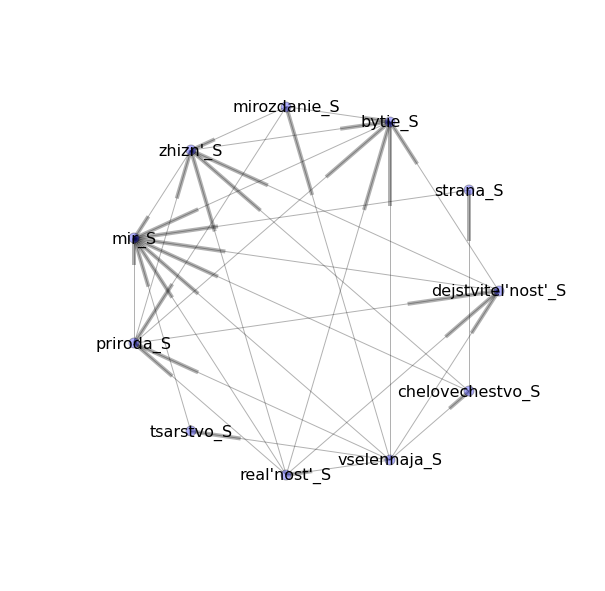

In [23]:
draw_rng(build_rng('мир_S'.decode('utf8'), model))

In [29]:
connectivities = {}

for i in range(100):
    word = process_word(i, data)
    try:
        wg = build_rng(word, model)
        connectivity = nx.average_node_connectivity(wg)
        connectivities[word] = connectivity
    except: # Word not in model
        pass

show **high** connectivity word-graphs

In [32]:
for i in connectivities:
    c = connectivities[i]
    if c > 1:
        print i, '\t', c

пойти_V 	1.13636363636
иметь_V 	1.05454545455
сторона_S 	1.17272727273
город_S 	1.06363636364
земля_S 	1.19090909091
спросить_V 	1.54545454545
хороший_A 	1.21818181818
последний_A 	1.45454545455
взять_V 	1.10909090909
время_S 	1.1
часть_S 	1.09090909091
считать_V 	1.39090909091
большой_A 	1.1


show **low** connectivity word-graphs

In [36]:
for i in connectivities:
    c = connectivities[i]
    if c < 0.4:
        print i, '\t', c

очень_ADV 	0.272727272727
глаз_S 	0.381818181818
высокий_A 	0.254545454545
слово_S 	0.145454545455
делать_V 	0.372727272727
мочь_V 	0.318181818182
отец_S 	0.354545454545
голова_S 	0.327272727273
машина_S 	0.190909090909
право_S 	0.372727272727
женщина_S 	0.318181818182
